Create Pathology Dataset and its variants

In [ ]:
import pandas as pd
from utils.TumorClassification import TumorClassificationSimple
from datasets import Dataset, DatasetDict, load_from_disk
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
original_dataset = pd.read_json('')
len(original_dataset), original_dataset.columns

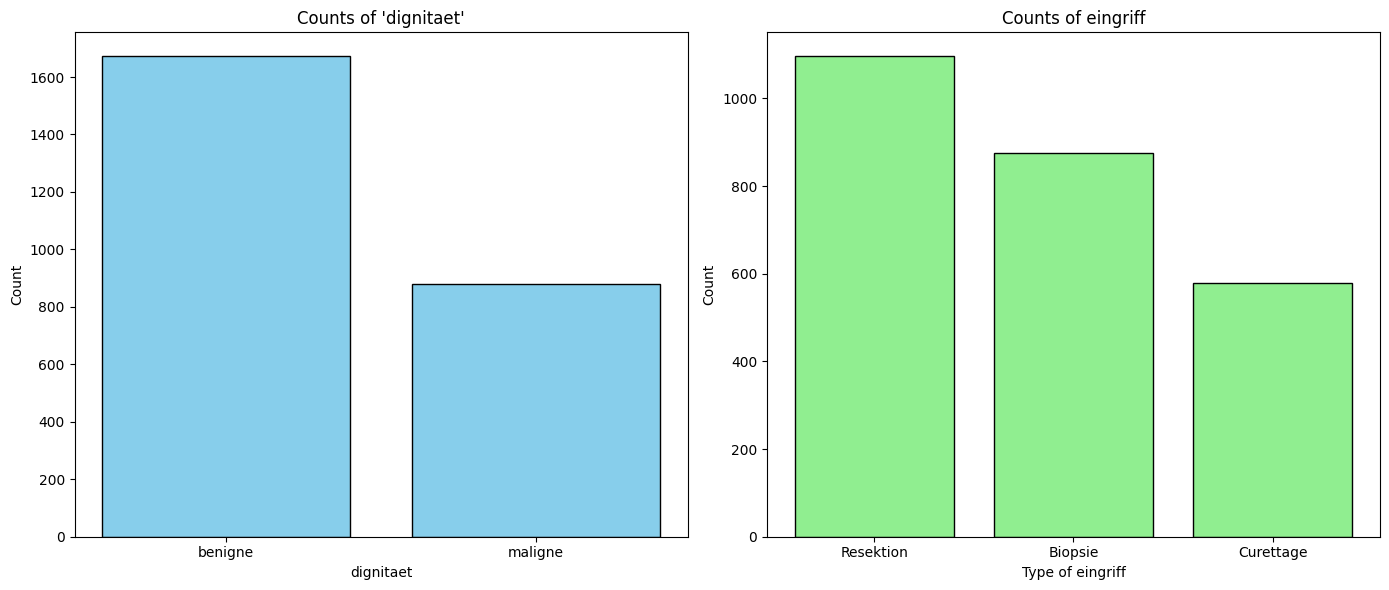

In [3]:
dignity_counts = original_dataset['dignitaet'].value_counts()
eingriff_counts = original_dataset['eingriff'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(dignity_counts.index, dignity_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title("Counts of 'dignitaet'")
axes[0].set_xlabel("dignitaet")
axes[0].set_ylabel("Count")

axes[1].bar(eingriff_counts.index, eingriff_counts.values, color='lightgreen', edgecolor='black')
axes[1].set_title("Counts of eingriff")
axes[1].set_xlabel("Type of eingriff")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
original_dataset.iloc[0]['label_privacy']

In [3]:
# Create a new column "combination" to stratify based on "dignitaet" and "eingriff"
def normalize_dignitaet(d):
  if d not in ['benigne', 'maligne']:
    print(d)
    return random.choice(['benigne', 'maligne'])
  return d

original_dataset['combination'] = original_dataset.apply(
  lambda row: f"{normalize_dignitaet(row['dignitaet'])}_{row['eingriff'].lower()}",
  axis=1
)

# Perform stratified splits: Train (80%), Validation (10%), Test (10%)
train_set, temp_set = train_test_split(
  original_dataset, test_size=0.2, random_state=42, stratify=original_dataset['combination']
)
val_set, test_set = train_test_split(
  temp_set, test_size=0.5, random_state=42, stratify=temp_set['combination']
)

print("Train set shape:", train_set.shape)
print("Validation set shape:", val_set.shape)
print("Test set shape:", test_set.shape)

None
None
Train set shape: (2041, 23)
Validation set shape: (255, 23)
Test set shape: (256, 23)


In [4]:
train_data = [] 
val_data = []
test_data = []
for _, sample in train_set.iterrows():
    train_data.append({
        'text': sample['text'],
        'label': TumorClassificationSimple.from_dataframe(sample).model_dump_json()
    }
    )
for _, sample in val_set.iterrows():
    val_data.append({
        'text': sample['text'],
        'label': TumorClassificationSimple.from_dataframe(sample).model_dump_json()
    }
    )
for _, sample in test_set.iterrows():
    test_data.append({
        'text': sample['text'],
        'label': TumorClassificationSimple.from_dataframe(sample).model_dump_json()
    }
    )

In [5]:
train_data[0]['label']

'{"intervention":"Resektion","dignity":"benigne","entity":"Lipoma arborescens","subentity":null,"location":"Knie links"}'

In [6]:
# Create a DatasetDict with train, validation, and test splits
strat_dataset_dict = DatasetDict({
  'train': Dataset.from_pandas(pd.DataFrame(train_data)),
  'validation': Dataset.from_pandas(pd.DataFrame(val_data)),
  'test': Dataset.from_pandas(pd.DataFrame(test_data))
})

print(strat_dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2041
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 255
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 256
    })
})


In [ ]:
strat_dataset_dict.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 2041/2041 [00:00<00:00, 231042.17 examples/s]


Saving the dataset (1/1 shards): 100%|██████████| 256/256 [00:00<00:00, 118527.63 examples/s]


In [7]:
data = [] 
for _, sample in original_dataset.iterrows():
    data.append({
        'text': sample['text'],
        'label': TumorClassificationSimple.from_dataframe(sample).model_dump_json()
    }
    )

In [8]:
data = pd.DataFrame(data)
dataset = Dataset.from_pandas(data)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train (90%) and temp (10%)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# Split the temp data into validation (5%) and test (5%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f'Train size: {len(train_data)}')
print(f'Validation size: {len(val_data)}')
print(f'Test size: {len(test_data)}')

In [ ]:
# Create a DatasetDict with train, validation, and test splits
dataset_dict = DatasetDict({
  'train': Dataset.from_pandas(train_data),
  'validation': Dataset.from_pandas(val_data),
  'test': Dataset.from_pandas(test_data)
})

print(dataset_dict)

In [11]:
len(dataset_dict['train']), len(dataset_dict['validation']), len(dataset_dict['test'])

(2041, 255, 256)

In [ ]:
dataset_dict['train'][0]

In [ ]:
dataset_dict = dataset_dict.remove_columns(['__index_level_0__'])
dataset_dict.save_to_disk('')

Saving the dataset (0/1 shards):   0%|          | 0/2041 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 256/256 [00:00<00:00, 87523.79 examples/s]


In [ ]:
dataset = load_from_disk('')
len(dataset['train']), len(dataset['validation']), len(dataset['test'])

(2041, 255, 256)

In [ ]:
task_description = open('').read()
task_description = task_description.split('Size: ')[0]

In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('meta-llama/LLaMa-3.2-1B')

In [49]:
len(tokenizer.tokenize(task_description))

714

In [ ]:
dataset = load_from_disk('')

In [50]:
def generate_prompt(example):
  """
  Given one example (with a pathology report in example['text'] and a label in example['label']),
  generate a prompt that instructs the model to extract tumor-related information.
  """
  prompt = (
      f"You are a helpful assistant. Your task is to extract the following tumor related information from a German "
      f"bone and soft tissue tumor pathology report:\n"
      f"{task_description}\n"
      f"Besides classifying the tumor based on the given criteria, you should also retrieve the text sequences that contain "
      f"the tumor information. The tumor information should be classified according to the following schema:\n"
      f"{TumorClassificationSimple.model_json_schema()}\n"
      f"Retrieve and extract the relevant information from the following report:\n"
      f"{example['text']}\n\n" + example['label'].strip() + tokenizer.eos_token
  )
  return prompt

In [ ]:
# Function to compute the length of tokenized text
def compute_tokenized_length(example):
  return {'tokenized_length': len(tokenizer(generate_prompt(example))["input_ids"])}

# Apply the function to the dataset
tokenized_lengths = dataset.map(compute_tokenized_length, batched=False)

# Print the tokenized lengths for the first few examples
print(tokenized_lengths['train']['tokenized_length'])
print(tokenized_lengths['validation']['tokenized_length'])
print(tokenized_lengths['test']['tokenized_length'])

In [55]:
sorted_lengths = sorted(tokenized_lengths['train']['tokenized_length'], reverse=True)
print(sorted_lengths[:10])

[5055, 4789, 4432, 3834, 3756, 3697, 3671, 3668, 3617, 3568]


In [ ]:
import numpy as np

# Extract tokenized lengths for train, validation, and test sets
train_lengths = tokenized_lengths['train']['tokenized_length']
validation_lengths = tokenized_lengths['validation']['tokenized_length']
test_lengths = tokenized_lengths['test']['tokenized_length']

lengths = np.concatenate([train_lengths, validation_lengths, test_lengths])

# Compute mean and median for each set
mean_train = np.mean(train_lengths)
median_train = np.median(train_lengths)

mean_validation = np.mean(validation_lengths)
median_validation = np.median(validation_lengths)

mean_test = np.mean(test_lengths)
median_test = np.median(test_lengths)

mean_general = np.mean(lengths)
median_general = np.median(lengths)

print(f"Train - Mean: {mean_train}, Median: {median_train}")
print(f"Validation - Mean: {mean_validation}, Median: {median_validation}")
print(f"Test - Mean: {mean_test}, Median: {median_test}")
print(f"General - Mean: {mean_general}, Median: {median_general}")

Train - Mean: 1026.361587457129, Median: 889.0
Validation - Mean: 1093.4705882352941, Median: 920.0
Test - Mean: 1013.93359375, Median: 879.0


In [ ]:
tokenized_lengths['train']['text'][0]

In [10]:
def preprocess_function(example, tokenizer, input_language, task_description, schema, max_length=4520):

  def generate_prompt(example, input_language, task_description, schema):

    prompt = (
        f"You are a helpful assistant. Your task is to extract the following tumor related information from a {input_language} "
        f"bone and soft tissue tumor pathology report:\n"
        f"{task_description}\n"
        f"Besides classifying the tumor based on the given criteria, you should also retrieve the text sequences that contain "
        f"the tumor information. The tumor information should be classified according to the following schema:\n"
        f"{schema}\n"
        f"Retrieve and extract the relevant information from the following report:\n"
        f"{example['text']}\n\n"
    )
    return prompt


  prompt = generate_prompt(example, input_language, task_description, schema)
  response = example['label'].strip() + tokenizer.eos_token
  full_text = prompt + response

  tokenized_full = tokenizer(
    full_text,
    truncation=True,
    max_length=max_length,
    padding="max_length"
  )


  tokenized_prompt = tokenizer(
      prompt,
      truncation=True,
      max_length=max_length,
  )
  prompt_len = len(tokenized_prompt["input_ids"])
  labels = tokenized_full["input_ids"].copy()
  labels[:prompt_len] = [-100] * prompt_len
  tokenized_full["labels"] = labels


  if "label" in tokenized_full:
    del tokenized_full["label"]

  return tokenized_full

In [6]:
tokenizer.pad_token = tokenizer.eos_token

In [29]:
preproc_sample = preprocess_function(dataset['train'][0], tokenizer, "German", task_description, TumorClassificationSimple.model_json_schema())

4520
1684


In [30]:
preproc_sample.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
def tokenize_example(example):
  return preprocess_function(example, tokenizer, "german", task_description, TumorClassificationSimple.model_json_schema())

train_dataset = dataset["train"]
val_dataset = dataset["validation"]
tokenized_train_dataset = train_dataset.map(tokenize_example, batched=False, remove_columns=["label", "text"])

In [ ]:
for i, batch in enumerate(tokenized_train_dataset):
  print(batch)
  break

In [ ]:
original_dataset.iloc[1]['label_privacy'], original_dataset.iloc[1]['text'].find('Raimund Mühle')

In [4]:
piis_50 = []
piis_100 = []
for _, row in original_dataset.iterrows():
    for pii in row['label_privacy']:
      text = row['text']
      text = text[:pii['start']]
      for mask_pii in row['label_privacy']:
        text = text.replace(mask_pii['text'], mask_pii['entity_type'])
      tokenized_text = tokenizer(text)
      len_tokenized = len(tokenized_text['input_ids'])
      if len_tokenized > 50:
        piis_50.append({'input': tokenizer.decode(tokenized_text['input_ids'][-50:]), 'target': pii['text'], 'type': pii['entity_type']})
        if len_tokenized > 100:
          piis_100.append({'input': tokenizer.decode(tokenized_text['input_ids'][-100:]), 'target': pii['text'], 'type': pii['entity_type']})
      

In [ ]:
piis_50[15]

In [5]:
len(piis_50), len(piis_100)

(11896, 11717)

In [ ]:
df = pd.DataFrame(piis_50).to_excel('', index=False)

In [ ]:
df = pd.DataFrame(piis_100).to_excel('', index=False)

In [ ]:
df = pd.read_excel('')
len(df)

11717

In [21]:
df = df.dropna(subset=['input', 'target'])
len(df)

11714

In [22]:
dataset = Dataset.from_pandas(df)

In [23]:
len(dataset)

11714

In [ ]:
dataset.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 11714/11714 [00:00<00:00, 548949.49 examples/s]


In [27]:
# Create stratified train and test splits with representation of all classes
# First let's count how many of each class we have in the dataset
benign_count = 0
maligne_count = 0
unknown_count = 0
biopsy_count = 0
curettage_count = 0
resektion_count = 0
for _,sample in original_dataset.iterrows():
  if sample['dignitaet'] == 'benigne':
    benign_count += 1
  elif sample['dignitaet'] == 'maligne':
    maligne_count += 1
  else:
    unknown_count += 1
  if sample['eingriff'] == 'Biopsie':
    biopsy_count += 1
  elif sample['eingriff'] == 'Curettage':
    curettage_count += 1
  else:
    resektion_count += 1


In [23]:
benign_count, maligne_count, unknown_count, biopsy_count, curettage_count, resektion_count, (benign_count + maligne_count + unknown_count) , (biopsy_count + resektion_count + curettage_count)

(1672, 878, 2, 876, 580, 1096, 2552, 2552)

In [ ]:
combinations = {
  'benign_biopsie': 0,
  'benign_curettage': 0,
  'benign_resektion': 0,
  'maligne_biopsie': 0,
  'maligne_curettage': 0,
  'maligne_resektion': 0,
  'unknown_biopsie': 0,
  'unknown_curettage': 0,
  'unknown_resektion': 0
}

In [30]:
# Create stratified train and test splits with representation of all classes
# First let's count how many of each class we have in the dataset
for _,sample in original_dataset.iterrows():
  if sample['dignitaet'] == 'benigne':
    if sample['eingriff'] == 'Biopsie':
      combinations['benign_biopsie'] += 1
    elif sample['eingriff'] == 'Curettage':
      combinations['benign_curettage'] += 1
    elif sample['eingriff'] == 'Resektion':
      combinations['benign_resektion'] += 1
    
  elif sample['dignitaet'] == 'maligne':
    if sample['eingriff'] == 'Biopsie':
      combinations['maligne_biopsie'] += 1
    elif sample['eingriff'] == 'Curettage':
      combinations['maligne_curettage'] += 1
    elif sample['eingriff'] == 'Resektion':
      combinations['maligne_resektion'] += 1
  else:
    print(sample['dignitaet'])
    if sample['eingriff'] == 'Biopsie':
      combinations['unknown_biopsie'] += 1
    elif sample['eingriff'] == 'Curettage':
      combinations['unknown_curettage'] += 1
    elif sample['eingriff'] == 'Resektion':
      combinations['unknown_resektion'] += 1


None
None


In [26]:
combinations

{'benign_biopsie': 490,
 'benign_curettage': 499,
 'benign_resektion': 683,
 'maligne_biopsie': 384,
 'maligne_curettage': 81,
 'maligne_resektion': 413,
 'unknown_biopsie': 2,
 'unknown_curettage': 0,
 'unknown_resektion': 0}

In [12]:
TumorClassificationSimple.from_dataframe(original_dataset.iloc[0])

TumorClassificationSimple(intervention='Biopsie', dignity='benigne', entity='Riesenzelltumor', subentity=None)

In [13]:
train_data = [] 
val_data = []
test_data = []
for _, sample in train_set.iterrows():
    model = TumorClassificationSimple.from_dataframe(sample)
    train_data.append({
        'text': sample['text'],
        'label': f"The classification of the intervantion is: {model.intervention}, the tumor is:  {model.dignity}, the entity is: {model.entity} and subentity is: {model.subentity}"
    }
    )
for _, sample in val_set.iterrows():
    model = TumorClassificationSimple.from_dataframe(sample)
    val_data.append({
        'text': sample['text'],
        'label': f"The classification of the intervantion is: {model.intervention}, the tumor is:  {model.dignity}, the entity is: {model.entity} and subentity is: {model.subentity}"
    }
    )
for _, sample in test_set.iterrows():
    model = TumorClassificationSimple.from_dataframe(sample)
    test_data.append({
        'text': sample['text'],
        'label': f"The classification of the intervantion is: {model.intervention}, the tumor is:  {model.dignity}, the entity is: {model.entity} and subentity is: {model.subentity}"
    }
    )

In [14]:
train_data[0]['label']

'The classification of the intervantion is: Resektion, the tumor is:  benigne, the entity is: Lipoma arborescens and subentity is: None'

In [ ]:
# Create a DatasetDict with train, validation, and test splits
unstructured_dataset_dict = DatasetDict({
  'train': Dataset.from_pandas(pd.DataFrame(train_data)),
  'validation': Dataset.from_pandas(pd.DataFrame(val_data)),
  'test': Dataset.from_pandas(pd.DataFrame(test_data))
})

print(unstructured_dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2041
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 255
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 256
    })
})


In [ ]:
unstructured_dataset_dict.save_to_disk('')

Saving the dataset (1/1 shards): 100%|██████████| 256/256 [00:00<00:00, 52500.58 examples/s]


In [ ]:
# PII Analysis
pii_types_count = {}
piis_count = {}
for _, sample in original_dataset.iterrows():
    print(sample['label_privacy'])
    for pii in sample['label_privacy']:
      entity = pii['entity_type']
      text = pii['text']
      print(f"Entity: {entity}, Text: {text}")
      if entity not in pii_types_count:
        pii_types_count[entity] = 1
      else:
        pii_types_count[entity] += 1
      if text not in piis_count:
        piis_count[text] = 1
      else:
        piis_count[text] += 1

In [ ]:
pii_types_count, piis_count

In [ ]:
print(len(piis_count))
print(sorted(piis_count.items(), key=lambda x: x[1], reverse=True)[:10])



In [ ]:
real_dataset = pd.read_json('')

# PII Analysis
real_pii_types_count = {}
real_piis_count = {}
for _, sample in real_dataset.iterrows():
    # print(sample['label_privacy'])
    for pii in sample['label_privacy']:
      entity = pii['labels']
      text = pii['text']
      # print(f"Entity: {entity}, Text: {text}")
      if entity not in real_pii_types_count:
        real_pii_types_count[entity] = 1
      else:
        real_pii_types_count[entity] += 1
      if text not in real_piis_count:
        real_piis_count[text] = 1
      else:
        real_piis_count[text] += 1

print(real_pii_types_count, real_piis_count)
print(len(real_piis_count))
print(sorted(real_piis_count.items(), key=lambda x: x[1], reverse=True)[:10])


In [ ]:
dataset = load_from_disk('')
len(dataset['train']), dataset['train'].features

(2041,
 {'text': Value(dtype='string', id=None),
  'label': Value(dtype='string', id=None)})

In [ ]:
pii_types_count = {}
piis_count = {}
for _, sample in dataset['train'].iterrows():
    # print(sample['label_privacy'])
    for pii in sample['label_privacy']:
      entity = pii['labels']
      text = pii['text']
      # print(f"Entity: {entity}, Text: {text}")
      if entity not in pii_types_count:
        pii_types_count[entity] = 1
      else:
        pii_types_count[entity] += 1
      if text not in piis_count:
        piis_count[text] = 1
      else:
        piis_count[text] += 1

print(pii_types_count, piis_count)
print(len(piis_count))
print(sorted(piis_count.items(), key=lambda x: x[1], reverse=True)[:10])


In [ ]:
# Plot top N most frequent PIIs in real and faker datasets
top_n = 20

# Real dataset
real_sorted = sorted(real_piis_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
real_piis, real_cnts = zip(*real_sorted)

plt.figure(figsize=(12, 6))
plt.bar(real_piis, real_cnts, color='skyblue', edgecolor='black')
plt.title(f"Top {top_n} Most Frequent PII in Real Dataset")
plt.xlabel("PII")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Faker dataset
faker_sorted = sorted(piis_count.items(), key=lambda x: x[1], reverse=True)[:top_n]
faker_piis, faker_cnts = zip(*faker_sorted)

plt.figure(figsize=(12, 6))
plt.bar(faker_piis, faker_cnts, color='lightgreen', edgecolor='black')
plt.title(f"Top {top_n} Most Frequent PII in Faker Dataset")
plt.xlabel("PII")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Plot top 10 PII for both faker and real datasets side by side
top_n = 10
faker_top = faker_sorted[:top_n]
real_top = real_sorted[:top_n]

faker_labels, faker_counts = zip(*faker_top)
real_labels, real_counts     = zip(*real_top)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Faker dataset plot
axes[0].bar(faker_labels, faker_counts, color='lightgreen', edgecolor='black')
axes[0].set_title(f"Top {top_n} Most Frequent PII – Faker Dataset")
axes[0].set_xlabel("PII")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

# Real dataset plot
axes[1].bar(real_labels, real_counts, color='skyblue', edgecolor='black')
axes[1].set_title(f"Top {top_n} Most Frequent PII – Real Dataset")
axes[1].set_xlabel("PII")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

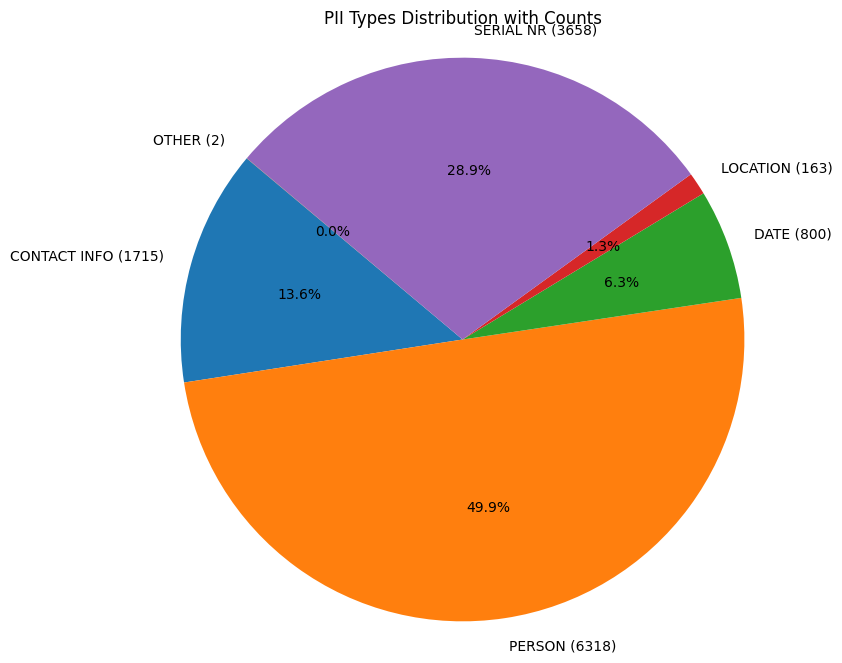

In [18]:
from matplotlib import pyplot as plt

labels_with_counts = [f"{key} ({value})" for key, value in pii_types_count.items()]
sizes = list(pii_types_count.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_counts, autopct='%1.1f%%', startangle=140)
plt.title('PII Types Distribution with Counts')
plt.axis('equal')
plt.show()

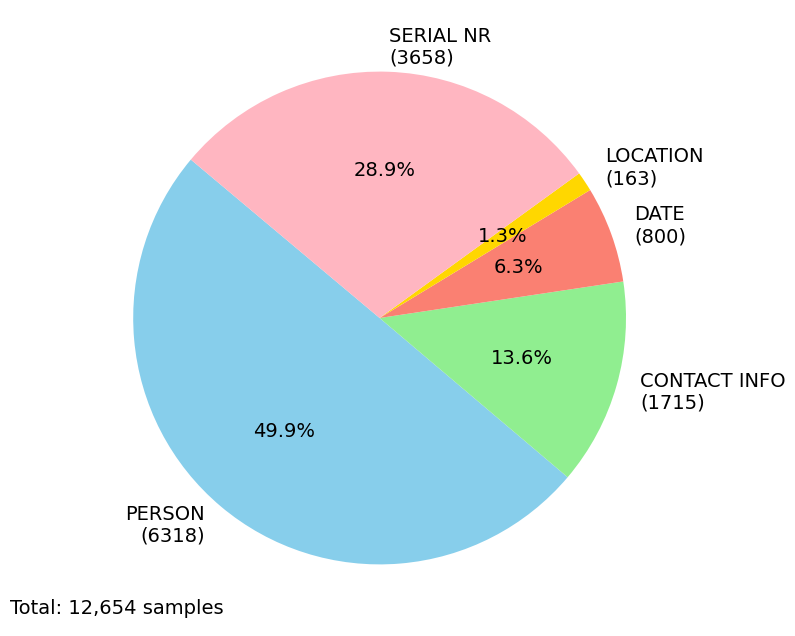

In [ ]:
pii_types_count = {
  'PERSON': 6318,
  'CONTACT INFO': 1715,
  'DATE': 800,
  'LOCATION': 163,
  'SERIAL NR': 3658
}
total = sum(pii_types_count.values())

labels_with_counts = [f"{key}\n({value})" for key, value in pii_types_count.items()]
sizes = list(pii_types_count.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, 
        labels=labels_with_counts, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightpink', 'lightyellow', 'lightblue', 'lightgrey'],
        textprops={'fontsize': 14}
        )
plt.text(-1.5, -1.2, f'Total: {total:,} samples', fontsize=14)

# plt.title('PII Types Distribution with Counts')
# plt.axis('equal')
# plt.show()
plt.savefig('', dpi=450, bbox_inches='tight')


In [9]:
total_counts = sum(pii_types_count.values())
total_counts

12656

In [7]:
# PII Analysis
counted_piis = []
unique_pii_types_count = {"PERSON": 0, "CONTACT INFO": 0, "DATE": 0, "LOCATION": 0, "SERIAL NR": 0, 'OTHER' : 0}
for _, sample in original_dataset.iterrows():
    for pii in sample['label_privacy']:
      pii_text = pii['text']
      entity = pii['entity_type']
      if pii_text not in counted_piis:
        counted_piis.append(pii_text)
        unique_pii_types_count[entity] += 1

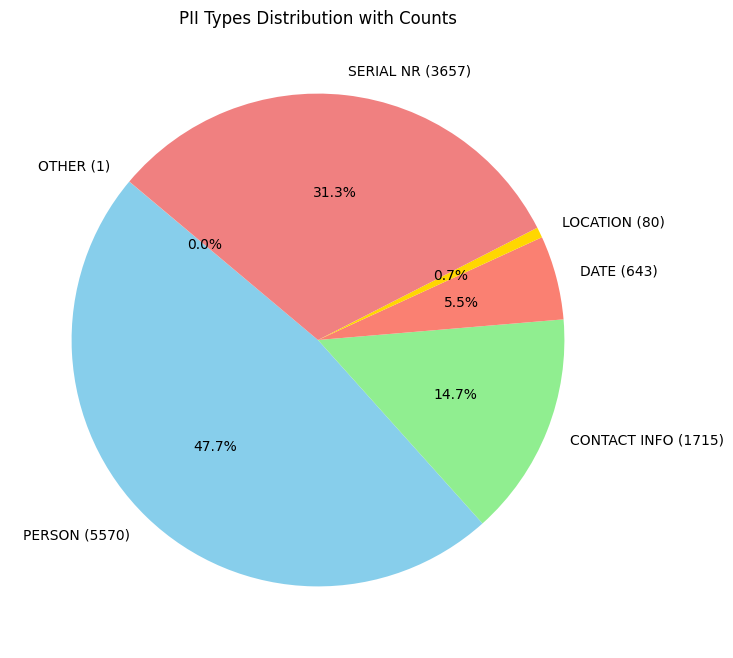

In [8]:
labels_with_counts = [f"{key} ({value})" for key, value in unique_pii_types_count.items()]
sizes = list(unique_pii_types_count.values())

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_counts, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral', 'lightsalmon'])
plt.title('PII Types Distribution with Counts')
# plt.axis('equal')
plt.show()

In [ ]:
top_n = 30
multiplier = 0
sorted_counts = dict(sorted(piis_count.items(), key=lambda item: item[1], reverse=True)[top_n*multiplier:top_n+top_n*multiplier])
piis = list(sorted_counts.keys())
counts = list(sorted_counts.values())

# Create the bar plot
plt.figure(figsize=(20, 8))
plt.bar(piis, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("PIIs")
plt.ylabel("Frequency")
plt.title("PIIs Histogram")

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)

# Add count values on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + max(counts) * 0.01, str(count), 
            ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

In [57]:
piis_count['Ulm']

6

In [ ]:
for pii in extracted_piis:
  print(pii, piis_count[pii])

In [ ]:
# Inspect the texts
texts = []
for _, sample in original_dataset.iterrows():
  texts.append(sample['text'])

print(texts[0])

In [ ]:
with open('', 'w') as f:
  for text in texts:
    f.write(text + '\n\n#################\n---------------------------------\n#################\n\n')

In [46]:
def find_all_occurrences(input_str, substr):
    start = 0
    while start < len(input_str) and start != -1:
        start = input_str.find(substr, start)
        if start != -1: 
          last_occurrence = start
          start += 1
    return last_occurrence
        

In [ ]:
index = find_all_occurrences(original_dataset.iloc[1]['text'].lower(), 'kritischer befundbericht:')
print(original_dataset.iloc[1]['text'])
print("-------------------")
print(original_dataset.iloc[1]['text'][index+len("kritischer befundbericht:"):])

In [50]:
kritisches = 0
telefons = 0
texts = []
for _, sample in original_dataset.iterrows():
  krit_text = sample['text']
  if "kritischer befundbericht:" in krit_text.lower():
    kritisches += 1
    index = find_all_occurrences(krit_text.lower(), 'kritischer befundbericht:')
    krit_text = krit_text[index+len("kritischer befundbericht:"):]
    if "Telefon für" in krit_text or "elefon für" in krit_text:
      telefons += 1
      if "Telefon für" in krit_text:
        krit_text = krit_text.split('Telefon für')[0]
      else:
        krit_text = krit_text.split('elefon für')[0]  
  texts.append(krit_text)

print(len(original_dataset), kritisches, telefons)

2552 2547 956


In [ ]:
with open('', 'w') as f:
  for text in texts:
    f.write(text + '\n\n#################\n---------------------------------\n#################\n\n')